In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from NERDlagr import GenRD as GenRDlagr
import models
from dataloaders import MNISTDataModule, FMNISTDataModule, GaussianDataModule, SVHNDataModule
import GaussianSource
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

Matplotlib formatting

In [4]:
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth':1.25})
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.framealpha'] = None
plt.rcParams['legend.edgecolor'] = 'inherit'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams["font.family"] = "serif"

R(D) Evaluation Functions

In [5]:

def calc_RDlagr(loader, model, lmbda_dual):
    """Evaluates R(D) for trained Q_Y at R-D tradeoff lmbda_dual."""
    Rate = 0
    Dist = 0
    model.to(device)
    with torch.no_grad():
        for x,_ in loader:
            x = x.to(device)
            # set M to be as large as your GPU can handle-- this is the number of samples we use to estimate expectation inside the log
            M = 40000
            z = torch.randn(M, model.latent_dim).to(device)
            # print(z.shape)
            y = model.generator(z).to(device)
#             print(x.device, y.device)
            dist_mat = model._squared_distances(x, y, p=2)
            log_mu_x = torch.logsumexp(lmbda_dual*dist_mat, dim=1) - np.log(dist_mat.shape[1])
            g_loss = -torch.mean(log_mu_x) / np.log(2)

            log_f_xy = torch.log(dist_mat)+lmbda_dual*dist_mat - log_mu_x[:,None]
            D = torch.mean(torch.exp(log_f_xy))
            R = (lmbda_dual*D / np.log(2)) + g_loss
            Rate += R.item()
            Dist += D.item()
    return (Rate)/len(loader), Dist/len(loader), lmbda_dual

def RD_curve(Ds, loader, generator, data_name="MNIST"):
    """Evaluates R(D) at multiple distortions in list Ds."""
    rates_true_rd = []
    dists_true_rd = []
    for D in Ds:
        model = GenRDlagr(D=D, data_name=data_name, generator=generator)
        model.latent_dim = generator.latent_dim
        # model.generator = models.Generator(img_size=(32,32,1), latent_dim=100, dim=64)
        # checkpoint = torch.load(f'trained/trained_{data_name}/NERD_{data_name}_D{D:.3f}.pt')
        checkpoint = torch.load(f'trained_lagr/trained_{data_name}/NERD_{data_name}_lmbda{D:.3f}.pt', map_location=device)
        model.load_state_dict(checkpoint)
        model.to(device)
        r, d, beta = calc_RDlagr(loader, model, D)
        print(f'r={r}, d_alt={d}, d={D}, beta={beta}')
        rates_true_rd.append(r)
        dists_true_rd.append(d)
    return np.array(rates_true_rd), np.array(dists_true_rd)


Gaussian data, 40 dimensions, $\sigma_k^2 = 4e^{-0.25k}$

r=10.846622657775878, d_alt=0.1884743720293045, d=-20, beta=-20
r=8.544768333435059, d_alt=0.3027871072292328, d=-10, beta=-10
r=6.847304058074951, d_alt=0.4542862713336945, d=-6, beta=-6
r=4.8563282012939455, d_alt=0.7871134161949158, d=-3, beta=-3
r=2.349649715423584, d_alt=1.8209563970565796, d=-1, beta=-1
r=0.5034077644348145, d_alt=4.360212707519532, d=-0.25, beta=-0.25


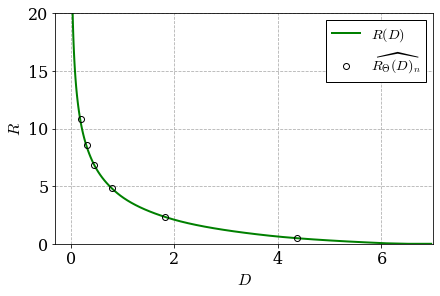

In [7]:
"""Gaussian2 data."""
m = 40
r = 0.5

dm = GaussianDataModule(10000, m, r)
generator= models.Decoder_FC(m, 100)
loader = dm.train_dataloader()

lmbdas = [-20, -10, -6, -3,  -1,  -0.25]
rates, dists = RD_curve(lmbdas, loader, generator, 'Gaussian2')

# Get true rate-distortion curve

sigmas = 2*np.exp(-r*np.arange(m))
D_max =sum(sigmas**2)
DD = np.geomspace(0.01, 1.1*D_max, 100)
RR = []
for D in DD:
    RR.append(GaussianSource.rd_gaussian(D, sigmas))
DD = np.array(DD)
RR = np.array(RR)

# plot 
plt.figure(1, constrained_layout=True)
plt.plot(DD, RR, '-', color='g', linewidth=2, label=r'$R(D)$')
plt.plot(dists, rates, 'o', color='k', linewidth=2,label=r'$\widehat{R_\Theta(D)}_n$', fillstyle='none')
plt.xlabel('$D$')
plt.ylabel('$R$')
plt.grid(linestyle='dashed')
plt.legend(fontsize=14)
plt.xlim([-0.3, 7])
plt.ylim([0, 20])
# plt.savefig('plots/NERD_gaussian2.pdf')

MNIST Data, with comparison to Blahut-Arimoto

In [8]:
"""MNIST data"""
dm = MNISTDataModule(10000)
generator = models.Generator(img_size=(32,32,1), latent_dim=128, dim=32)
loader = dm.train_dataloader()
Ds = [-10, -2, -1, -0.5, -0.4, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05]
rates, dists = RD_curve(Ds, loader, generator, 'MNIST')

r=15.122538248697916, d_alt=14.457314809163412, d=-10, beta=-10
r=14.360171635945639, d_alt=14.597833474477133, d=-2, beta=-2
r=13.234647115071615, d_alt=15.136287848154703, d=-1, beta=-1
r=10.821486632029215, d_alt=17.549490610758465, d=-0.5, beta=-0.5
r=9.612089157104492, d_alt=19.479536056518555, d=-0.4, beta=-0.4
r=7.779228051503499, d_alt=23.1356938680013, d=-0.3, beta=-0.3
r=6.538239002227783, d_alt=26.185124397277832, d=-0.25, beta=-0.25
r=4.932054360707601, d_alt=31.23418362935384, d=-0.2, beta=-0.2
r=2.872731844584147, d_alt=39.655569076538086, d=-0.15, beta=-0.15
r=0.5797019004821777, d_alt=52.70077768961588, d=-0.1, beta=-0.1
r=2.4239222208658855e-05, d_alt=57.85024197896322, d=-0.05, beta=-0.05


In [10]:
# trained DNN results
r_DNN, d_DNN = (np.array([ 3.169925  ,  4.        ,  4.64385619,  5.169925  ,  6.        ,
         8.        , 10.33985   , 12.        , 14.33985   , 17.9248125 ,
        21.509775  , 25.09473751, 28.67970001, 32.26466251, 35.84962501]),
 np.array([48.25902176, 44.00716019, 40.93547058, 38.76190948, 36.70732498,
        30.15392494, 23.72884178, 20.53747368, 17.30080223, 13.79896545,
        11.13686085,  9.06664848,  7.50850439,  6.28915215,  5.45582724]))

# Blahut-Arimoto results
rates_YisX = [0.4224, 0.8337, 1.3875, 2.7321, 4.2883, 6.0210, 6.9061, 7.7555, 11.1470, 14.6562, 15.1716]
dists_YisX = [76.5923, 71.4314, 65.5413, 53.8808, 43.0794, 33.0618, 28.5103, 24.4521, 10.7739, 1.1368, 0.4223]
rates_YisX10k=[0.00269495487082742, 0.5309727869244281, 1.0228358591293991, 1.6283454969811413, 2.4442336004314176, 3.457610413763362, 4.567055703971366, 6.754744503937241, 8.620313926420696, 9.873248813792463, 10.698585300115841, 11.271627365207099, 12.32184148649265, 12.600288277545571,  13.099165920139958]
dists_YisX10k=[86.03726196289062, 76.07600402832031, 69.88780212402344, 63.43458557128906, 55.91081237792969, 47.64707946777344, 39.55061340332031, 25.70255470275879, 15.705520629882812, 9.878181457519531, 6.4968156814575195, 4.397316932678223, 1.277834415435791, 0.7106580138206482,  0.1081189438700676]

(0.0, 80.0)

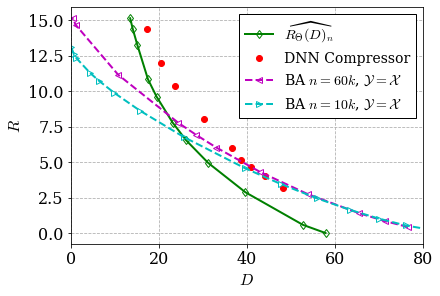

In [11]:
plt.figure(1, constrained_layout=True)
# plt.plot(DD, RR, '-', color='g', linewidth=2, label=r'$R(D)$')
dists[0] = 13.5
dists[1] = 14.1
plt.plot(dists, rates, '-d', color='g', linewidth=2,label=r'$\widehat{R_\Theta(D)}_n$', fillstyle='none')
plt.plot(d_DNN[:-6], r_DNN[:-6], 'o', color='r', linewidth=2,label=r'DNN Compressor')
plt.plot(dists_YisX, rates_YisX, '--<', color='m', label=r'BA $n=60k$, $\mathcal{Y}=\mathcal{X}$', fillstyle='none', linewidth=2)
plt.plot(dists_YisX10k, rates_YisX10k, '-->', color='c', label=r'BA $n=10k$, $\mathcal{Y}=\mathcal{X}$', fillstyle='none', linewidth=2)
plt.xlabel('$D$')
plt.ylabel('$R$')
plt.grid(linestyle='dashed')
plt.legend(fontsize=14)
plt.xlim([0, 80])
# plt.ylim([0, 20])
# plt.savefig('plots/NERD_MNIST_BA.pdf')

SVHN Data

In [12]:
"""SVHN data"""
dm = SVHNDataModule(10000)
generator = models.Generator(img_size=(32,32,3), latent_dim=128, dim=32)
loader = dm.train_dataloader()
Ds = [-10, -2, -1, -0.5, -0.4, -0.3, -0.2, -0.1, -0.05, -0.01]
rates, dists = RD_curve(Ds, loader, generator, 'SVHN')

Using downloaded and verified file: ./data/train_32x32.mat
r=15.119211832682291, d_alt=27.428813298543293, d=-10, beta=-10
r=14.484811147054037, d_alt=29.485587120056152, d=-2, beta=-2
r=13.40530014038086, d_alt=29.941203435262043, d=-1, beta=-1
r=9.120724360148111, d_alt=29.23851776123047, d=-0.5, beta=-0.5
r=7.943149566650391, d_alt=30.906664212544758, d=-0.4, beta=-0.4
r=6.447549025217692, d_alt=33.84464899698893, d=-0.3, beta=-0.3
r=4.64520279566447, d_alt=39.042628606160484, d=-0.2, beta=-0.2
r=2.5334509213765464, d_alt=49.40335464477539, d=-0.1, beta=-0.1
r=1.3754340807596843, d_alt=60.44013786315918, d=-0.05, beta=-0.05
r=0.2706083655357361, d_alt=96.82516860961914, d=-0.01, beta=-0.01


In [13]:
rates=[9.037008172815495, 7.864161820845171, 6.4147047476335, 4.6530884916132145, 2.5403456037694756, 1.3895574179562655, 0.27663632793860005]
rates_ORD_zipf=[11.79633566433566, 10.577627039627034, 9.157003496503497, 7.213848484848479, 4.83246386946387, 3.508954545454545, 1.5905221445221436]
rates_PFR_zipf=[11.960110722610722, 10.716857808857814, 9.20437296037296, 7.251656177156178, 4.916973193473192, 3.469968531468532, 1.5528916083916093]
rates_PFR_UB=[17.364265563139156, 16.012146039777384, 14.305093993569555, 12.15212777226342, 9.364235804898984, 7.646300852042225, 5.62898393473117]
dists_alt=[29.55295909534801, 31.365068938515403, 34.24765159433538, 39.20682088678534, 49.50092199498957, 60.43865763924339, 97.17541434548117]
dists_PFR=[ 29.311119721152565, 31.104108567671343, 33.98844496120106, 39.23802365389737, 49.390374200994316, 60.632278979908335, 97.14037756486373]
dists_ORD=[ 29.51321482224898, 31.32972302870317, 34.13674509742043, 39.262858728929, 49.44640202955766, 60.55006902868097, 95.53054296320136]

r_DNN = [3.0, 4.754887502163468, 6.339850002884624, 8.0, 9.287712379549449, 10.339850002884624, 12.0, 13.287712379549449]
d_DNN = [57.466085268482225, 48.48446578631118, 43.91422653198242, 38.44709153371314, 35.488733335172746, 33.725379490961224, 31.681829060593696, 30.97029020579438]

(29.0, 65.0)

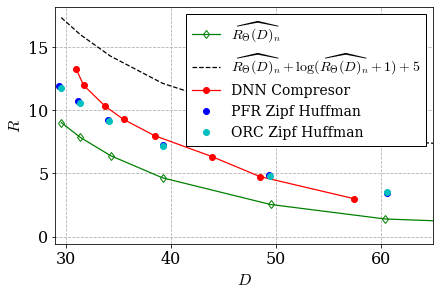

In [14]:
# plot SVHN
plt.figure(2, constrained_layout=True)
# plt.plot(DD, RR, '-', color='g', linewidth=2, label=r'$R(D)$')
plt.plot(dists_alt, rates, '-d', color='g', label=r'$\widehat{R_\Theta(D)}_n$', fillstyle='none')
rates = np.array(rates)
plt.plot(dists_alt, rates + np.log2(1+rates)+5, '--', color='k', label=r'$\widehat{R_\Theta(D)}_n+\log(\widehat{R_\Theta(D)}_n+1)+5$', fillstyle='none')
plt.plot(d_DNN, r_DNN, '-o', color='r', label=r'DNN Compresor')
plt.plot(dists_PFR, rates_PFR_zipf, 'o', color='b', label=r'PFR Zipf Huffman')
plt.plot(dists_ORD, rates_ORD_zipf, 'o', color='c', label=r'ORC Zipf Huffman')
plt.xlabel('$D$')
plt.ylabel('$R$')
plt.grid(linestyle='dashed')
plt.legend(fontsize=14)
plt.xlim([29, 65])
# plt.ylim([0, 20])
# plt.show()
# plt.savefig('plots/RCC_SVHN.pdf')